# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from tqdm import tqdm
from PIL import Image, ImageFile 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


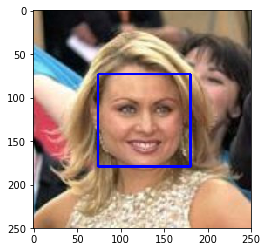

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[100])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:

from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

"""

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

count_humans = 0
count_dogs = 0

for img in human_files_short:
    if face_detector(img) == True:
        count_humans += 1
        
for img in dog_files_short:
    if face_detector(img) == True:
        count_dogs += 1
        
print('%.1f%% images of the first 100 human_files were detected as human face.' % count_humans)
print('%.1f%% images of the first 100 dog_files were detected as human face.' % count_dogs)
"""

"\n\n#-#-# Do NOT modify the code above this line. #-#-#\n\n## TODO: Test the performance of the face_detector algorithm \n## on the images in human_files_short and dog_files_short.\n\ncount_humans = 0\ncount_dogs = 0\n\nfor img in human_files_short:\n    if face_detector(img) == True:\n        count_humans += 1\n        \nfor img in dog_files_short:\n    if face_detector(img) == True:\n        count_dogs += 1\n        \nprint('%.1f%% images of the first 100 human_files were detected as human face.' % count_humans)\nprint('%.1f%% images of the first 100 dog_files were detected as human face.' % count_dogs)\n"

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:35<00:00, 15399571.86it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

In [8]:
#VGG16

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
#from PIL import Image
#import torchvision.transforms as transforms

In [10]:
def image_to_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    
    transformations = transforms.Compose([transforms.Resize(size=224),
                                         transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor

# Denormalizing the image and converting it to Numpy image
def img_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.225, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

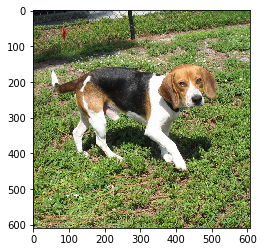

In [11]:
dog_image = Image.open('/data/dog_images/train/016.Beagle/Beagle_01125.jpg')
plt.imshow(dog_image)
plt.show()

torch.Size([1, 3, 224, 224])


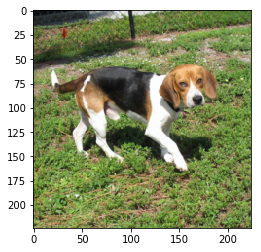

In [12]:
test_tensor = image_to_tensor('/data/dog_images/train/016.Beagle/Beagle_01125.jpg')
print(test_tensor.shape)
plt.imshow(img_convert(test_tensor))

In [13]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image_tensor = image_to_tensor(img_path)
    
    # Use CUDA fd available
    if use_cuda:
        imgage_tensor = image_tensor.cuda()
        
    output = VGG16(image_tensor)
    
    _, predicted_tensor = torch.max(output, 1)
    prediction = np.squeeze(predicted_tensor.numpy()) if not use_cuda else np.squeeze(predicted_tensor.cpu.numpy())
    
    return int(prediction)

In [14]:
# import requests
# import ast

LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"

def get_human_readable_label_for_class_id(class_id):
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)
    print(f"Label:{labels[class_id]}")
    return labels[class_id]
    
img_path = '/data/dog_images/train/016.Beagle/Beagle_01125.jpg'     
test_prediction = VGG16_predict(img_path)
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)
print(f"Predicted class for image is: {class_description.upper()}")

Predicted class id: 162
Label:beagle
Predicted class for image is: BEAGLE


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    
    return ((prediction >= 151) & (prediction <= 268)) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [16]:
"""
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

detected_dogs_in_humans = 0
detected_dogs_in_dogs = 0

for i in range(100):
    if dog_detector(human_files_short[i]):
        detected_dogs_in_humans += 1
        #print(f"This human ({image}) looks like a dog.")
        
    if dog_detector(dog_files_short[i]):
        detected_dogs_in_dogs += 1
        
print(f"Percentage of the images in human_files_short that have a detected dog: {detected_dogs_in_humans}")   
print(f"Percentage of the images in dog_files_short that have a detected dog: {detected_dogs_in_dogs}")
"""

'\n### TODO: Test the performance of the dog_detector function\n### on the images in human_files_short and dog_files_short.\n\ndetected_dogs_in_humans = 0\ndetected_dogs_in_dogs = 0\n\nfor i in range(100):\n    if dog_detector(human_files_short[i]):\n        detected_dogs_in_humans += 1\n        #print(f"This human ({image}) looks like a dog.")\n        \n    if dog_detector(dog_files_short[i]):\n        detected_dogs_in_dogs += 1\n        \nprint(f"Percentage of the images in human_files_short that have a detected dog: {detected_dogs_in_humans}")   \nprint(f"Percentage of the images in dog_files_short that have a detected dog: {detected_dogs_in_dogs}")\n'

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [17]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [42]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 16
num_workers = 0

transform = transforms.Compose([transforms.Resize(size = 224),
                                transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Defining data loaders for training, validation, and test sets
data_dir = '/data/dog_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform)
                  for x in ['train', 'valid', 'test']}
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=num_workers)
    for x in ['train', 'valid', 'test']}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer:**
The above code cell will split data into train, valid and test datasets.
The DataLoader function will load the data into train, valid and test datasets with shuffling on.

The code will resize the images to 224 pixels with CenterCrop and  
augmantation is done by randomly horizontally flipping and ratating the images.
I used this method because it's a standard procedure followed in data cleaning.

The images we are working with in this project are of size (224,224,3). Most of the pretrained models use 224*224 images 
and the code will normalize the input images to the standard mean and std sizes.

**Answer**:

In [44]:
classe_names = image_datasets['train'].classes
num_classes = len(classe_names)

print('Number of classes', num_classes)
#print('\n\nClass Names:', classe_names)

Number of classes 133


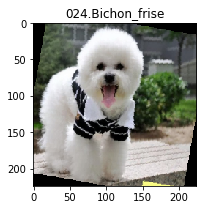

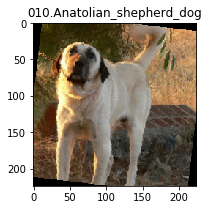

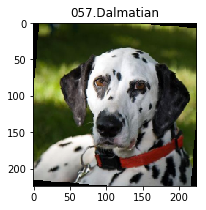

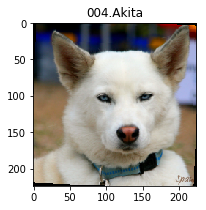

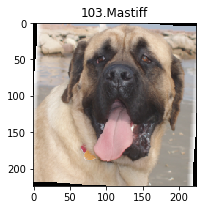

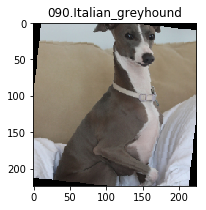

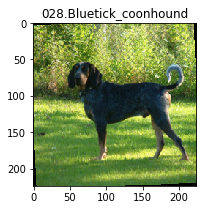

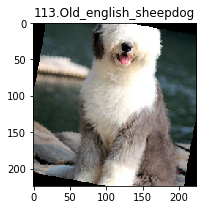

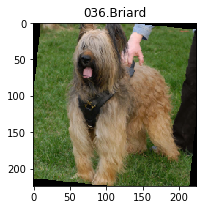

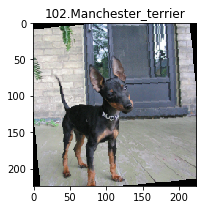

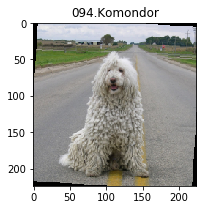

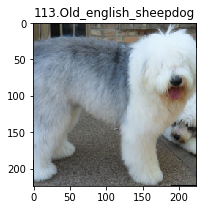

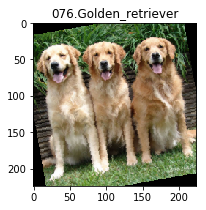

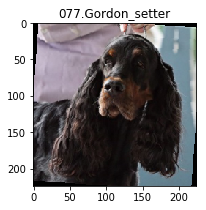

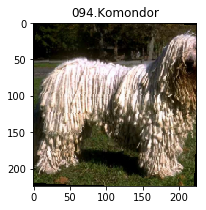

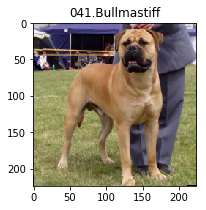

In [45]:
# Get a batch of training data
inputs, classes = next(iter(loaders['train']))

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(classe_names[label])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [46]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # Convolutional layer sees 16*
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # Convolutional layer sees 8*8*32 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        
        # Dropout layer with p=0.25
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        
        # Add dropout layer
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        
        # Add dropout layer
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        
        # Add dropout layer 
        x = self.dropout(x)
        
        # Flatten the input image 
        x = x.view(x.size(0), -1)
        
        # First hidden layer
        x = F.relu(self.batch_norm(self.fc1(x)))
        
        # Add dropout layer
        x = self.dropout(x)
        
        # Add second hidden layer with RELU activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
This model's input have a shape of (224,224,3) and output have 133 classes.
I have used torch.nn.Conv2d (https://pytorch.org/docs/stable/nn.html#conv2d) for convolutional layers and torch.nn.MaxPool2d (https://pytorch.org/docs/stable/nn.html#maxpool2d) for maxpooling layers as both the packages works well for computer vision applications.
More convolutional layers will help the model to understand the complex patterns in images like shape and colors. 
First convolutional layer will have 3 channels in the input image, 16 filters of size 3*3. We will move one pixel at a time so the stride is of size 1*1. Padding of 1*1 will be added to the both sides of the input so this layer will have the same width and height as the input layer.
By using the same method, second convolutional layer will have the parameters (16, 32, 3, padding=1) and last convolutional layer will have parameters (32, 64, 3, padding=1).

I have used MaxPooling layer with kernal_size=2 and stride=2 after every convolutional layer to downsample the input by the factor of 2. 

I have used fully connected linear layer for 133 output classes and the dropout layer with p=0.25 will avoid overfitting. 
Forward pass would give:

`torch.Size([16, 3, 224, 224])`

`torch.Size([16, 16, 112, 112])`

`torch.Size([16, 32, 56, 56])`

`torch.Size([16, 64, 28, 28])`

`torch.Size([16, 50176])`

`torch.Size([16, 500])`

`torch.Size([16, 133])`

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [47]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [48]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = 3.877533 #np.Inf 
    
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [49]:
# train the model
model_scratch = train(2, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.753808 	Validation Loss: 4.770793
Epoch: 2 	Training Loss: 4.495348 	Validation Loss: 4.661009


In [52]:
# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [57]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        test_loss += loss.item()*data.size(0)
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    # print the losses
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [58]:
# test the accuracy    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3895.867773


Test Accuracy:  2% (20/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [60]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch
print(loaders_transfer)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f188dc6c710>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f188dc5f0b8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f188dbb0a20>}


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [61]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 110207003.33it/s]


In [62]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I have used a pre-trained model called resnet50 which is widely used for classification tasks. This model is trained using imagenet which contains more than 14 million images.



In [63]:
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
# Replace the last fully connected layer with a Linnear layer with 133 out features
model_transfer.fc = nn.Linear(2048, 133)
if use_cuda:
    model_transfer = model_transfer.cuda()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [64]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [65]:
# train the model
n_epochs = 2
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 2.023053 	Validation Loss: 0.897682
Validation loss decreased (3.877533 --> 0.897682).  Saving model ...
Epoch: 2 	Training Loss: 0.762267 	Validation Loss: 0.600621
Validation loss decreased (0.897682 --> 0.600621).  Saving model ...


In [66]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [67]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 529.834290


Test Accuracy: 81% (678/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [69]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)
    
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
     # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

In [70]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

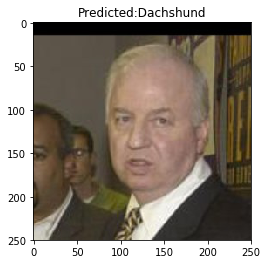

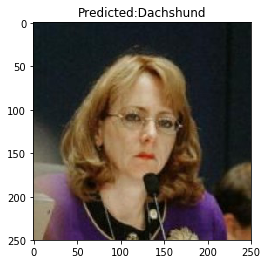

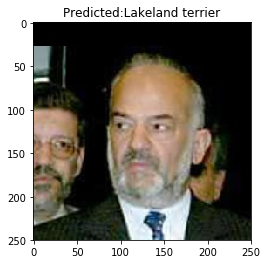

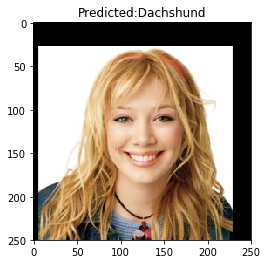

In [77]:
import random

# Try out the function
for image in random.sample(list(human_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title=f"Predicted:{predicted_breed}")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [78]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    # check if image has human faces:
    if (face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("You look like a ...")
        print(predicted_breed.upper())
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Doggie!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("Your breed is most likley ...")
        print(predicted_breed.upper())
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
    print("\n")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. Model should finetuned more.
2. May be I can use different pretrained models.
3. I can try using more convolutional layers.
4. Algorithm should detect correctly for multiple human or dogs in the same picture.
5. An algorithm with clean code might work better.

Hello Human!


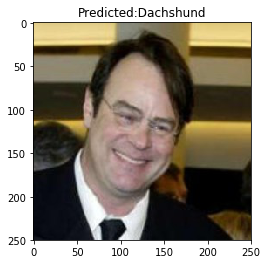

You look like a ...
DACHSHUND


Hello Human!


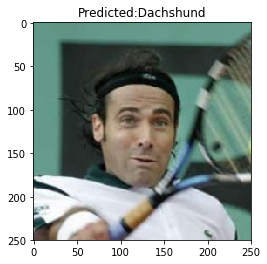

You look like a ...
DACHSHUND


Hello Human!


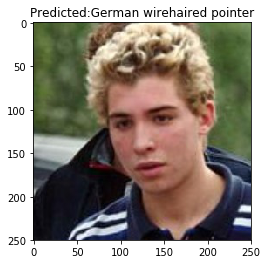

You look like a ...
GERMAN WIREHAIRED POINTER


Hello Doggie!


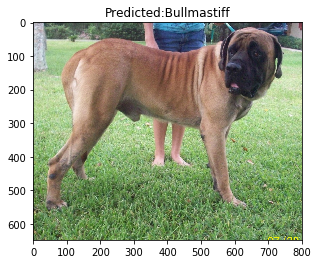

Your breed is most likley ...
BULLMASTIFF


Hello Doggie!


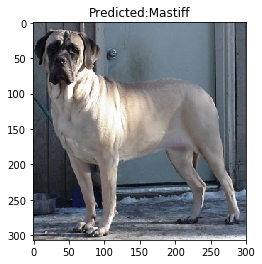

Your breed is most likley ...
MASTIFF


Hello Doggie!


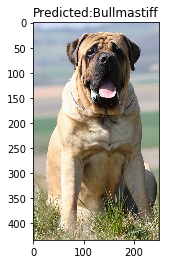

Your breed is most likley ...
BULLMASTIFF




In [76]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [81]:
# testing the app

run_app("/samples/baby.jpg")

error: /tmp/build/80754af9/opencv_1512491964794/work/modules/imgproc/src/color.cpp:11048: error: (-215) scn == 3 || scn == 4 in function cvtColor
